# Recommend songs based on spectrogram using pretrained embedding

### Import stuff

In [1]:
import os
import csv
import gensim
from gensim.models.callbacks import CallbackAny2Vec
import zipfile

try: # are we running on Google colab?
    # Load the Drive helper and mount
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
    os.environ["CUDA_VISIBLE_DEVICES"]="1"; ##########################################

if IN_COLAB:
    # This will prompt for authorization.
    drive.mount('/content/drive')

csv.field_size_limit(1000000); # for really long playlists!

C:\Users\tetic\Anaconda3\envs\Deep\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\tetic\Anaconda3\envs\Deep\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load in track data

In [2]:
if IN_COLAB and not os.path.exists('/tmp/spectrograms/'):
    print('Unzipping spectrograms...')
    zip_ref = zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/spectrograms.zip', 'r')
    zip_ref.extractall('/tmp/')
    zip_ref.close()
    os.chdir('/tmp/')

if IN_COLAB:
    spectrograms_dir = '/tmp/spectrograms/'
    checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/'
else:
    spectrograms_dir = './spectrograms/'
    checkpoint_dir = './'
    
print('Read in tracks...')
tracks = {}
with open(checkpoint_dir + 'tracks.csv', "r", encoding='utf-8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    for row in spamreader:
        columns = str(row)[2:-2].split(';')
        tracks[columns[0]] = [columns[1] + ' - ' +
                              columns[2], columns[3]] # title - artist, url
print(f'Number of tracks: {len(tracks)}')

Read in tracks...
Number of tracks: 3981436


### Load in track embedding

In [3]:
class logger(CallbackAny2Vec):
    None
    
embedding_model = gensim.models.Word2Vec.load(checkpoint_dir + 'word2vec.model')
print(embedding_model)

Word2Vec(vocab=452130, size=100, alpha=0.025)


Populating the interactive namespace from numpy and matplotlib


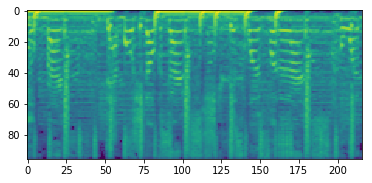

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(spectrograms_dir + 'train/000JCyEkMFumqCZQJAORiQ.png')
imgplot = plt.imshow(img)
plt.show()

In [5]:
time_steps = img.shape[1]
frequency_bands = img.shape[0]

In [6]:
embedding_norm = embedding_model.wv.syn0 #.copy()
for i, vector in enumerate(embedding_norm):
    norm = np.linalg.norm(embedding_norm[i], 2)
#    if norm != 0:
#        embedding_norm[i, :] = embedding_norm[i, :] / norm

C:\Users\tetic\Anaconda3\envs\Deep\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [7]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LeakyReLU, Flatten, Reshape, BatchNormalization
from keras.layers import Conv2DTranspose, SeparableConv2D, MaxPooling2D, UpSampling2D, Lambda, Permute

input_shape = (frequency_bands, time_steps, 1)
input_img = Input(input_shape, name='input')
x = input_img

x = SeparableConv2D(32, 3, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(rate=0.2)(x)

x = SeparableConv2D(64, 3, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(rate=0.3)(x)

x = SeparableConv2D(128, 3, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(rate=0.4)(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(1024)(x)
x = LeakyReLU(0.2)(x)
x = Dropout(rate=0.5)(x)
encoder = x

decoder_input = encoder
x = Dense(np.prod(shape_before_flattening[1:]))(decoder_input)
x = LeakyReLU(0.2)(x)
x = Dropout(rate=0.5)(x)

x = Reshape(shape_before_flattening[1:])(x)

x = Conv2DTranspose(64, 3, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(rate=0.4)(x)

x = Conv2DTranspose(32, 3, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(rate=0.3)(x)

x = Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(rate=0.2)(x)

decoder = x

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
from keras.callbacks import ModelCheckpoint, Callback

def plot_samples():
    for file in os.listdir(spectrograms_dir + 'test/'):
        track = file[0:-4]
        spectrogram = mpimg.imread(spectrograms_dir + 'test/' + file)
        img = ae.predict(np.expand_dims(np.expand_dims(spectrogram, axis=2), axis=0), batch_size=1)[0, :, :, 0]
        imgplot = plt.imshow(spectrogram)
        plt.show()
        imgplot = plt.imshow(img)
        plt.show()
    
class Test(Callback):
    def on_train_begin(self, logs={}):
        self.train_losses = []
        self.val_losses = []
        return
 
    def on_epoch_end(self, epoch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        ax=plt.figure(figsize=(10,4)).gca()
        plt.plot(1+np.arange(len(self.train_losses)), np.array(self.train_losses))
        plt.plot(1+np.arange(len(self.val_losses)), np.array(self.val_losses))
        plt.title('loss', fontsize=18)
        plt.ylabel('loss', fontsize=18)
        plt.legend(['train', 'val'], loc='upper left')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()
        plot_samples()
        return
    
def spectrogram_generator(directory, label_file, batch_size = 64):
    path = directory + label_file + '/'
    files = []
    for filename in os.listdir(path):
        files.append(filename)
    indices = np.random.permutation(len(files))
    i = 0
    while True:
        # Select files (paths/indices) for the batch
        start = i * batch_size
        end = start + batch_size
        batch = indices[start:end]
        batch_X = np.expand_dims(np.array([mpimg.imread(path + files[j]) for j in batch]), axis=3)
        batch_Y = batch_X
        i = i + 1
        if end >= len(files):
            i = 0
        yield(batch_X, batch_Y)

In [9]:
ae = Model(input_img, decoder)
ae.compile(optimizer="Adam", loss="mae")
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 96, 216, 1)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 96, 216, 32)       73        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 216, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 216, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 108, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 108, 32)       0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 48, 108, 64)       2400      
__________

In [10]:
ae.load_weights(checkpoint_dir + 'speccy_ae')
ae.fit_generator(spectrogram_generator(spectrograms_dir, 'train', batch_size=128),
                 steps_per_epoch=1000,
                 epochs=5000,
                 validation_data=spectrogram_generator(spectrograms_dir, 'val', batch_size=128),
                 validation_steps=100,
                 callbacks=[ModelCheckpoint(checkpoint_dir + 'speccy_ae', save_best_only=True), Test()])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5000
   1/1000 [..............................] - ETA: 18:48:02 - loss: 0.1578

KeyboardInterrupt: 

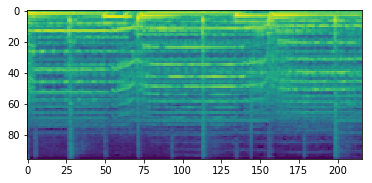

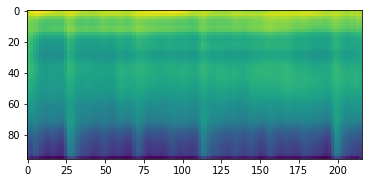

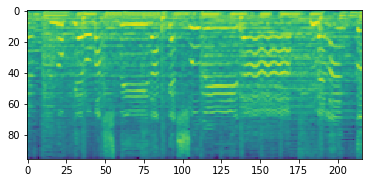

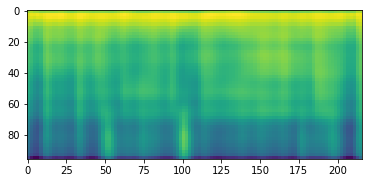

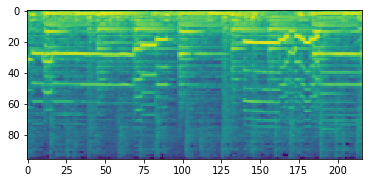

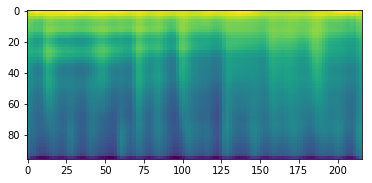

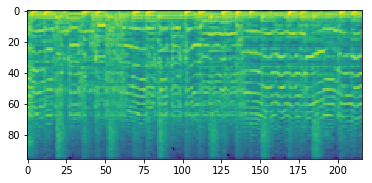

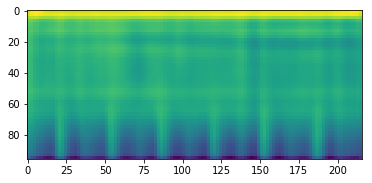

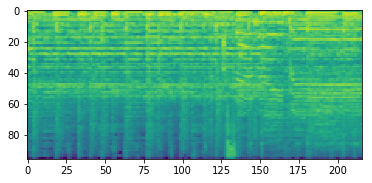

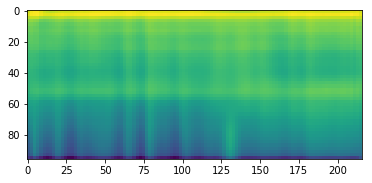

In [11]:
plot_samples()

### Search for a particular song id

In [ ]:
search = 'oasis'
for track in tracks:
    if tracks[track][0].lower().find(search.lower()) != -1 and track in embedding_model.wv.vocab:
        print(f'{track} : {tracks[track][0]} : {tracks[track][1]}')